In [1]:
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json
from glob import glob
import os

from importlib import reload

import utils

import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats
from sklearn import preprocessing, tree, metrics, linear_model

In [2]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.0
rng = np.random.default_rng(seed)
permmethod = stats.PermutationMethod(n_resamples=999, random_state=rng)

Cmap='plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
s = 50
alphaNmin = 0.1
alphaNmax = 10

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'RdPu_r', 'Greens_r', 'BuPu_r', 'Oranges_r', 'Wistia', 'YlOrBr_r', 'gray', 'gist_gray']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/' + sample + os.sep
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep + sample + os.sep
geosrc =  '..' + os.sep + 'geometry' + os.sep + sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
metaecc['eccentricity'] = metaecc['eccentricity'].max() - metaecc['eccentricity'].values

metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
cell_nuc.loc[cell_nuc['n_bot'] == 1, 'n_bot'] = 0
cell_nuc.loc[cell_nuc['n_top'] == 61, 'n_top'] = 65

transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
Cs = dict(zip(Genes, ['#56b4e9','#cc79a7']))
Ms = dict(zip(Genes, ['D','s']))
Ps = dict(zip(Genes, ['Blues_r','PuRd_r']))
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))
transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')
wcoords = np.asarray(np.nonzero(~wall))
foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = mpl.colors.ListedColormap(foo)

wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
    translocs[i]['cidx'] = label[ translocs[i]['Y'], translocs[i]['X'] ]
    translocs[i]['nidx'] =  lnuc[ translocs[i]['Y'], translocs[i]['X'] ]

tlocs = pd.concat(translocs)

Detected 2937 cells
Detected 1365 nuclei


# Bring in persistence images to the party

In [3]:
level = 'sub'
normtype = 'both'
stepsize = 3
bw = 25
SCALE = 32

zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

dsrc = isrc + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep
ratios = utils.normalize_counts(transfocus, normtype)

jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
gsrc = '../{}level/'.format(level) + sample + os.sep
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)

kde_max = np.zeros(ratios.size)
for i in range(len(orig_diags)):
    for j in range(len(orig_diags[i])):
        if len(orig_diags[i][j][focus_dim]) > 0:
            kde_max[i*len(orig_diags[i]) + j] = np.max(orig_diags[i][j][focus_dim])

kmax = np.sort(kde_max)[-20]

Initial number of life-birth pairs	: 64671

No. of diagrams s.t. H_k had the most persistent component
H_0:	26 [ 1.4% ]
H_1:	142 [ 7.7% ]
H_2:	1668 [ 90.8% ]

Will focus just on dimension k = 2



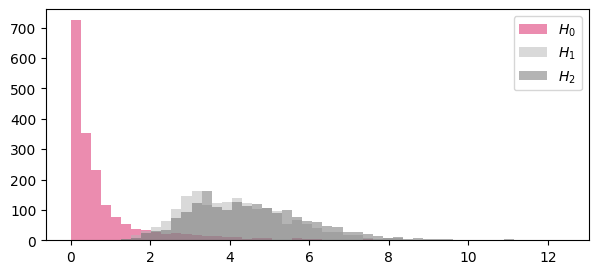

In [4]:
maxl = np.vstack(maxlife)
bins = np.linspace(0, maxl.max(), 50)

fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0
for i in range(maxl.shape[1]):
    ax[j].hist(maxl[:,i], bins=bins, color=wong[i], alpha=0.5, label='$H_{{{}}}$'.format(i))
ax[j].legend();

In [4]:
KBINS_NO = 27
foo = [pd.DataFrame(np.zeros((len(Genes), KBINS_NO-1)), index=Genes, columns=range(1,KBINS_NO)) for _ in range(len(Cells))]
peripherality = dict(zip( Cells, foo ))
for cidx in Cells:
    foo = pd.read_csv(geosrc + 'peripherality_c{:06d}.csv'.format(cidx))
    for gidx in Genes:
        ys = ratios[invGenes[gidx] , invCells[cidx]] * foo['mean_{}_-_{}'.format(bw, transcriptomes[gidx])].values / kmax
        peripherality[cidx].loc[gidx, :] = ys

In [5]:
kbins = np.linspace(0, 1, KBINS_NO)
Xs = np.linspace(0,1, peripherality[Cells[0]].shape[1])

pss=np.s_[6:len(Xs)-4]
xs = Xs[pss]
len(xs)

16

# Loadings

In [7]:
cidx = 2367
cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=True, PP=6)
s_ = (np.s_[cextent[2]:cextent[3]], np.s_[cextent[0]:cextent[1]])
edt = ndimage.distance_transform_edt(label[s_] == cidx)
edt = edt/edt.max()
axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, cell, label[s_], cextent, zmax, stepsize, cell_nuc)
alpha = min([1.5*int(4e6/cell.size)/100, 0.8])

cellhist = np.digitize(edt, kbins, right=True)
hsummary = [None for _ in range(len(Genes))]
hhist = [cellhist.copy() for _ in range(len(Genes))]

for i in range(len(Genes)):
    hsummary[i] = peripherality[cidx].loc[Genes[i]].values
    temp = (1e6*np.hstack(([0], hsummary[i]))).astype(int)
    with np.nditer(hhist[i], flags=['external_loop'], op_flags=['readwrite']) as it:
        for x in it:
            x[...] = temp[x]

    hsummary[i] = hsummary[i][pss]
#loc_smax = 1e6*max([ max(map(np.max, hsummary[i])) for i in range(len(hsummary)) ])

In [8]:
hcoords, hkde = [ [] for _ in range(2) ]

for gidx in Genes:

    coords = translocs[gidx].loc[ translocs[gidx]['cidx'] == cidx , ['X', 'Y', 'Z'] ].values.T
    
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(coords)))
    kde[outside_walls] = 0
    
    kde = kde/(np.sum(kde)*(stepsize**len(coords)))
    kde = kde.reshape( list(map(len, axes))[::-1], order='F')
       
    hkde.append( kde.copy() * ratios[invGenes[gidx]][invCells[cidx]] )
    hcoords.append(coords)

loc_kmax = max(map(np.max, hkde))
loc_smax = 1e6*loc_kmax/kmax

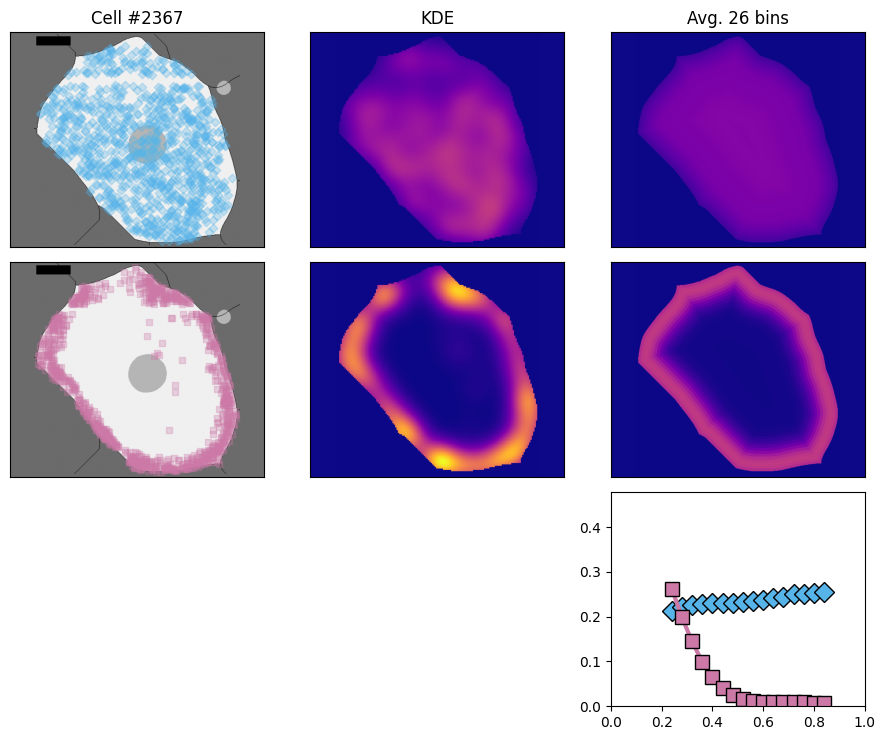

In [9]:
fig, ax = plt.subplots(3, 2+1, figsize=(6+3*1, 7.5), sharex=False, sharey=False)

for i in range(len(Genes)):
    j = 0
    ax[i,j].imshow(cell+1, cmap=cellular_cmap, origin='lower', extent=cextent, vmin=0, vmax=nnuc+2);
    ax[i,j].scatter(*(hcoords[i][:2]), color=Cs[Genes[i]], marker=Ms[Genes[i]], alpha=alpha, s=int(4e6/cell.size))
    ax[i,j].set_facecolor(wong[2])

    j += 1
    ax[i,j].imshow(np.max(hkde[i], axis=0), origin='lower', cmap=Cmap, vmin=0, vmax=loc_kmax, zorder=1)
    ax[i,j].set_facecolor( mpl.colormaps[ Cmap ](0) )

    j += 1
    ax[i, j].imshow(hhist[i], origin='lower', cmap=Cmap, vmin=0, vmax=loc_smax)
    ax[i, j].set_facecolor( mpl.colormaps[ Cmap ](0) )

ax[0,0].set_title('Cell #{}'.format(cidx), fontsize=fs)
ax[0,1].set_title('KDE', fontsize=fs)

i = 0
ax[0,2+i].set_title('Avg. {} bins'.format(KBINS_NO-1), fontsize=fs)
for j in range(len(Genes)):
    ax[2,2].plot(Xs[pss], hsummary[j], color=Cs[Genes[j]], lw=3, marker=Ms[Genes[j]], ms=10, mec='k', mew=1)
    ax[2,2].set_ylim(0, max([peripherality[cidx].max(axis=None), 0.3])+0.05);
    ax[2,2].set_xlim(0,1)

for ix in [(2,0), (2,1)]:
    fig.delaxes(ax[ix])
    

for a in ax.ravel()[:(4 + 2*1)]:
    a.set_aspect('equal','datalim')
    a.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout()
#plt.savefig('cell{}_periphery_analyses.png'.format(cidx), dpi=dpi, bbox_inches='tight', format='png')

#print(hsummary[0][0], '--', hsummary[1][0], sep='\n')

In [24]:
peripherality[cidx]

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
85,0.191964,0.226747,0.264733,0.298077,0.324749,0.344656,0.356364,0.363642,0.369024,0.371092,...,0.451235,0.489973,0.536932,0.591562,0.665985,0.737043,0.829513,0.947154,1.033658,1.057175
26,0.272838,0.301991,0.317876,0.317659,0.297324,0.266312,0.229724,0.187168,0.143522,0.107730,...,0.004400,0.003106,0.002457,0.002390,0.002216,0.001936,0.001729,0.001640,0.001475,0.001039


while


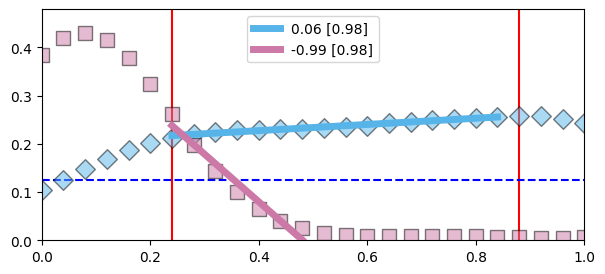

In [11]:
tol = 5e-4

fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].axvline(Xs[pss.start], c='r', zorder=1)
ax[j].axvline(Xs[pss.stop], c='r', zorder=1)
ax[j].axhline(0.125, c='b', ls='--', zorder=1)
for gidx in Genes:
#for gidx in [85]:
    
    t = transcriptomes[gidx] + '_-_'
    Ys = peripherality[cidx].loc[gidx].values
    tol_msk = (np.abs(Ys[pss] * np.ediff1d(Ys)[pss.start-1:pss.stop-1]) > tol) | (Ys[pss] > 0.125)
    while (np.sum(tol_msk) < 7) & (tol > 1e-5):
        print('while')
        tol /= 2
        tol_msk |= np.abs(Ys[pss] * np.ediff1d(Ys)[pss.start-1:pss.stop-1]) > tol
    tol_msk = utils.get_largest_element(tol_msk)
    dys = np.gradient(Ys, Xs, edge_order=1)[pss][tol_msk]
    uq, cts = np.unique(np.sign(dys), return_counts=True)
    sgn_msk = np.sign(dys + uq[np.argmax(cts)]*0.1) == uq[np.argmax(cts)]
    
    ys = Ys[pss][tol_msk][sgn_msk]
    xs = Xs[pss][tol_msk][sgn_msk]

    linregress = stats.linregress(xs, ys)
    m,b,r = linregress.slope, linregress.intercept, np.abs(linregress.rvalue)
    #print(t, metrics.mean_absolute_error(ys, m*xs + b), sep='\t')

    ax[j].scatter(Xs, Ys, color=Cs[gidx], marker=Ms[gidx], edgecolor='k', s=100, zorder=2, alpha=0.5)
    ax[j].plot( [ xs[0], xs[-1] ], [m*xs[0] + b, m*xs[-1]+b], c=Cs[gidx] , zorder=3, lw=5, label='{:.2f} [{:.2f}]'.format(m,r))

    #print('--\n', np.round(Ys[pss] * np.ediff1d(Ys)[pss.start-1:pss.stop], 5),'\n')
ax[j].legend()
ax[j].set_xlim(0,1)
ax[j].set_ylim(0, max([peripherality[cidx].max(axis=None), 0.3])+0.05);

In [6]:
cc = ['m', 'b', 'r', 'mae', 'start', 'stop']
colnames = []
for gidx in Genes:
    colnames += [ '{}_-_{}'.format(transcriptomes[gidx], c) for c in cc ]
    
colnames = np.asarray(colnames)

df = pd.DataFrame(np.zeros( (len(Cells), len(colnames)) ) , index=Cells, columns=colnames)
for cidx in Cells:
    for gidx in Genes:
        tol = 5e-4
        t = transcriptomes[gidx] + '_-_'
        Ys = peripherality[cidx].loc[gidx].values
        
        tol_msk = Ys[pss] > 0.125
        tol_msk |= np.abs(Ys[pss] * np.ediff1d(Ys)[pss.start-1:pss.stop-1]) > tol
        while (np.sum(tol_msk) < 6) & (tol > 1e-5):
            tol /= 2
            tol_msk |= np.abs(Ys[pss] * np.ediff1d(Ys)[pss.start-1:pss.stop-1]) > tol

        tol_msk = utils.get_largest_element(tol_msk)
        dys = np.gradient(Ys, Xs, edge_order=1)[pss][tol_msk]
        uq, cts = np.unique(np.sign(dys), return_counts=True)
        sgn_msk = np.sign(dys + uq[np.argmax(cts)]*0.1) == uq[np.argmax(cts)]
        
        ys = Ys[pss][tol_msk][sgn_msk]
        xs = Xs[pss][tol_msk][sgn_msk]
    
        linregress = stats.linregress(xs, ys)
        m,b,r = linregress.slope, linregress.intercept, np.abs(linregress.rvalue)
        mae = metrics.mean_absolute_error(ys, m*xs + b)
        
        df.loc[cidx, t + 'm'] = m
        df.loc[cidx, t + 'b'] = b
        df.loc[cidx, t + 'r'] = r
        df.loc[cidx, t + 'mae'] = mae
        df.loc[cidx, t + 'start'] = xs[0]
        df.loc[cidx, t + 'stop'] = xs[-1]
print(df.shape)

(918, 12)


In [7]:
df.sort_values(by='GLYMA_17G195900_-_mae', ascending=False).head(10)

,GLYMA_17G195900_-_m,GLYMA_17G195900_-_b,GLYMA_17G195900_-_r,GLYMA_17G195900_-_mae,GLYMA_17G195900_-_start,GLYMA_17G195900_-_stop,GLYMA_05G092200_-_m,GLYMA_05G092200_-_b,GLYMA_05G092200_-_r,GLYMA_05G092200_-_mae,GLYMA_05G092200_-_start,GLYMA_05G092200_-_stop
994,0.547023,0.160418,0.885449,0.045313,0.24,0.84,-0.829518,0.417000,0.990242,0.008147,0.24,0.48
931,0.295273,0.199918,0.771908,0.038259,0.24,0.84,-0.522914,0.238400,0.984516,0.005505,0.24,0.44
853,0.361148,-0.002777,0.835366,0.037534,0.24,0.84,-0.172273,0.076434,0.970462,0.002631,0.24,0.44
424,0.392991,0.047795,0.906646,0.028184,0.24,0.84,-0.077791,0.175536,0.949519,0.004274,0.24,0.84
652,0.276274,0.171845,0.896231,0.023180,0.24,0.84,-0.270903,0.360142,0.985102,0.006152,0.28,0.84
1752,0.113130,0.166740,0.623340,0.022854,0.24,0.84,-0.463905,0.208987,0.984290,0.005008,0.24,0.44
560,0.239468,0.243167,0.871994,0.021520,0.24,0.84,-0.594450,0.295636,0.995625,0.003435,0.24,0.44
693,0.273509,0.455299,0.898172,0.021196,0.24,0.84,-0.441231,0.397973,0.996123,0.005813,0.24,0.80
1349,0.265245,0.069403,0.903419,0.020039,0.24,0.84,-0.464195,0.229320,0.996728,0.002391,0.24,0.44
721,0.247357,0.251422,0.894947,0.019600,0.24,0.84,-0.566752,0.493349,0.992698,0.009913,0.24,0.80


In [8]:
df.describe()

,GLYMA_17G195900_-_m,GLYMA_17G195900_-_b,GLYMA_17G195900_-_r,GLYMA_17G195900_-_mae,GLYMA_17G195900_-_start,GLYMA_17G195900_-_stop,GLYMA_05G092200_-_m,GLYMA_05G092200_-_b,GLYMA_05G092200_-_r,GLYMA_05G092200_-_mae,GLYMA_05G092200_-_start,GLYMA_05G092200_-_stop
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,0.090215,0.210667,0.881417,0.005851,0.266885,0.830109,-0.415658,0.316482,0.971024,0.005010,0.248497,0.625403
std,0.106270,0.084246,0.152686,0.004259,0.062326,0.035857,0.218510,0.097040,0.094487,0.003066,0.028867,0.148336
min,-0.246366,-0.061357,0.015836,0.000616,0.240000,0.480000,-1.168281,0.058810,0.076195,0.000313,0.240000,0.440000
25%,0.030395,0.155234,0.854530,0.002866,0.240000,0.840000,-0.575826,0.247739,0.986111,0.002825,0.240000,0.480000
50%,0.084651,0.198089,0.935743,0.004995,0.240000,0.840000,-0.427635,0.315602,0.994039,0.004445,0.240000,0.600000
75%,0.152892,0.253081,0.972526,0.007620,0.240000,0.840000,-0.266805,0.382188,0.996791,0.006470,0.240000,0.790000
max,0.547023,0.646534,0.999510,0.045313,0.640000,0.840000,0.307333,0.751269,0.999776,0.026474,0.520000,0.840000


# Plot results

In [11]:
dst = geosrc + 'figs/'
cellloc = metacell.loc[Cells, ['ndimage_comX','ndimage_comY','orig_cellID']].values
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
metaecc['eccentricity'] = metaecc['eccentricity'].max() - metaecc['eccentricity'].values
ecc = metaecc.loc[Cells, 'eccentricity'].values

-0.15334986994424785	0.3366375560791967
-1.039355656759386	0.19672460396800645


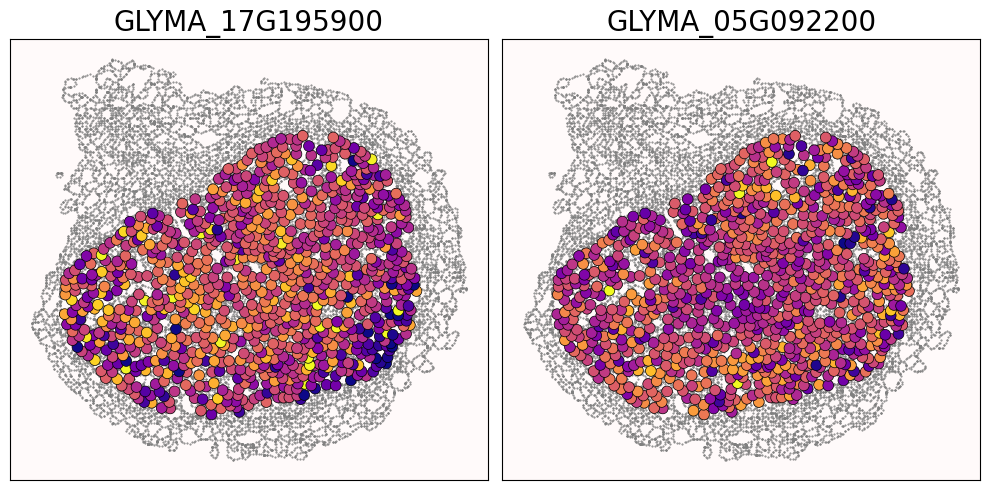

In [12]:
fs = 20
correcc = dict()
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for i in range(len(Genes)):
    gidx = Genes[i]
    t = transcriptomes[gidx]
    c = df[t+'_-_m'].values
    corr = stats.spearmanr(c, ecc)
    if corr.pvalue > 0:
        expo = int(np.ceil(np.log10(corr.pvalue)))
        ll = '$r_s = ${:.2f}\np$_\\mathregular{{val}}< 10^{{{}}}$'.format(corr.statistic, expo)
    else:
        ll = '$r_s = ${:.2f}\npval$= 0$'.format(corr.statistic)
    correcc[t] = ll
    
    vmax = utils.maximum_qq_size(c, alpha=0.25, iqr_factor=1.5)
    vmin = utils.minimum_qq_size(c, alpha=0.25, iqr_factor=1.5)

    ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=1, zorder=1)
    ax[i].scatter(*cellloc.T[:2], c=c, marker='o', cmap=Cmap+'_r',
                  edgecolor='black', linewidth=0.5, zorder=2, s=3*fs, vmax=vmax, vmin=vmin)
    ax[i].set_title(t, fontsize=fs)
    ax[i].set_facecolor('snow')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    print(vmin, vmax, sep='\t')
fig.tight_layout()
filename = dst + 'peripherality_nodule_spatial.png'
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

-0.15334986994424785	0.3366375560791967
-1.039355656759386	0.19672460396800645
../geometry/D2/figs/peripherality_eccentricity_spatial.png


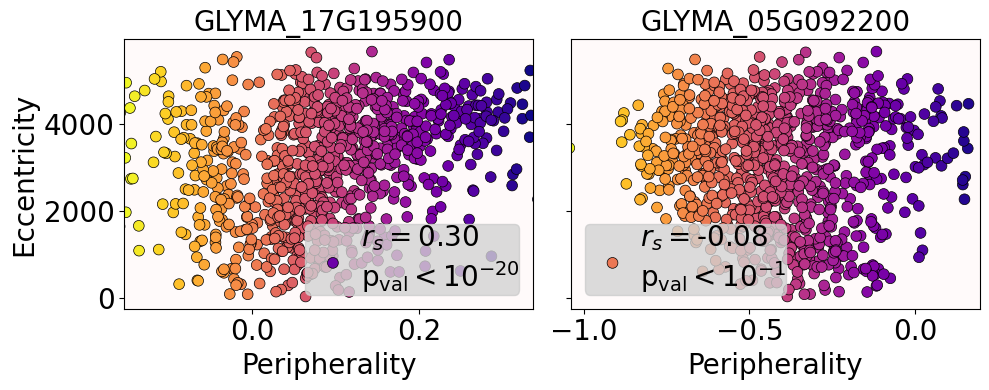

In [13]:
fs = 20
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=False, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for i in range(len(Genes)):
    gidx = Genes[i]
    t = transcriptomes[gidx]
    c = df[t+'_-_m'].values
    
    vmax = utils.maximum_qq_size(c, alpha=0.25, iqr_factor=1.5)
    vmin = utils.minimum_qq_size(c, alpha=0.25, iqr_factor=1.5)
    ax[i].scatter(c, ecc, c=c, marker='o', cmap=Cmap+'_r', edgecolor='black', linewidth=0.5, zorder=2, s=fs*3, vmax=vmax, vmin=vmin, label=correcc[t])
    ax[i].set_title(t, fontsize=fs)
    ax[i].set_facecolor('snow')
    ax[i].set_xlabel('Peripherality', fontsize=fs)
    ax[i].set_xlim(vmin, vmax)
    ax[i].legend(fontsize=fs, borderpad=0, handletextpad=0, facecolor='lightgray')
    ax[i].tick_params(labelsize=fs)
    print(vmin, vmax, sep='\t')
ax[0].set_ylabel('Eccentricity', fontsize=fs)
fig.tight_layout()
filename = dst + 'peripherality_eccentricity_spatial.png'
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

In [60]:
df[t+'_-_m']

169     0.235687
188     0.042093
199     0.061797
209     0.292838
224     0.105032
          ...   
2536    0.132408
2548    0.125335
2552    0.155358
2573    0.044105
2576    0.045059
Name: GLYMA_17G195900_-_m, Length: 918, dtype: float64

In [70]:
gidx = Genes[0]
t = transcriptomes[gidx]

N = 6
argsort = df[t+'_-_m'].argsort().values

cidxs = df.iloc[np.hstack( (argsort[:N], argsort[-N-1:-1]) )].index.values
cidxs

array([1035,  383, 1739,  882,  618, 1130,  730,  424,  340,  757, 1012,
        493])

In [71]:
cidxs = [2108, 2367, 1161, 730,  424,  340]

halpha, hkde, hedt, hcells, hcoords, hextent = [ [None for _ in range(len(cidxs))] for _ in range(6) ]

for i,cidx in enumerate(cidxs):
    cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=True, PP=6)
    s_ = (np.s_[cextent[2]:cextent[3]], np.s_[cextent[0]:cextent[1]])
    edt = ndimage.distance_transform_edt(label[s_] == cidx)
    edt = edt/edt.max()
    axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, cell, label[s_], cextent, zmax, stepsize, cell_nuc)
    
    cellhist = np.digitize(edt, kbins, right=True)
    temp = (1e6*np.hstack(([0], peripherality[cidx].loc[gidx].values))).astype(int)
    with np.nditer(cellhist, flags=['external_loop'], op_flags=['readwrite']) as it:
        for x in it:
            x[...] = temp[x]

    coords = translocs[gidx].loc[ translocs[gidx]['cidx'] == cidx , ['X', 'Y', 'Z'] ].values.T
    
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(coords)))
    kde[outside_walls] = 0
    
    kde = kde/(np.sum(kde)*(stepsize**len(coords)))
    kde = kde.reshape( list(map(len, axes))[::-1], order='F')
    
    hkde[i] = kde * ratios[invGenes[gidx]][invCells[cidx]]
    hcoords[i] = coords
    hcells[i] = cell
    halpha[i] = min([1.5*int(4e6/cell.size)/100, 0.8])
    hedt[i] = cellhist
    hextent[i] = cextent

loc_kmax = max(map(np.max, hkde))
loc_smax = 1e6*loc_kmax/kmax

In [73]:
gidxs = 3*[26] + 3*[85]
gidxs

[26, 26, 26, 85, 85, 85]

In [76]:
t

'GLYMA_17G195900'

../geometry/D2/figs/peripherality.png


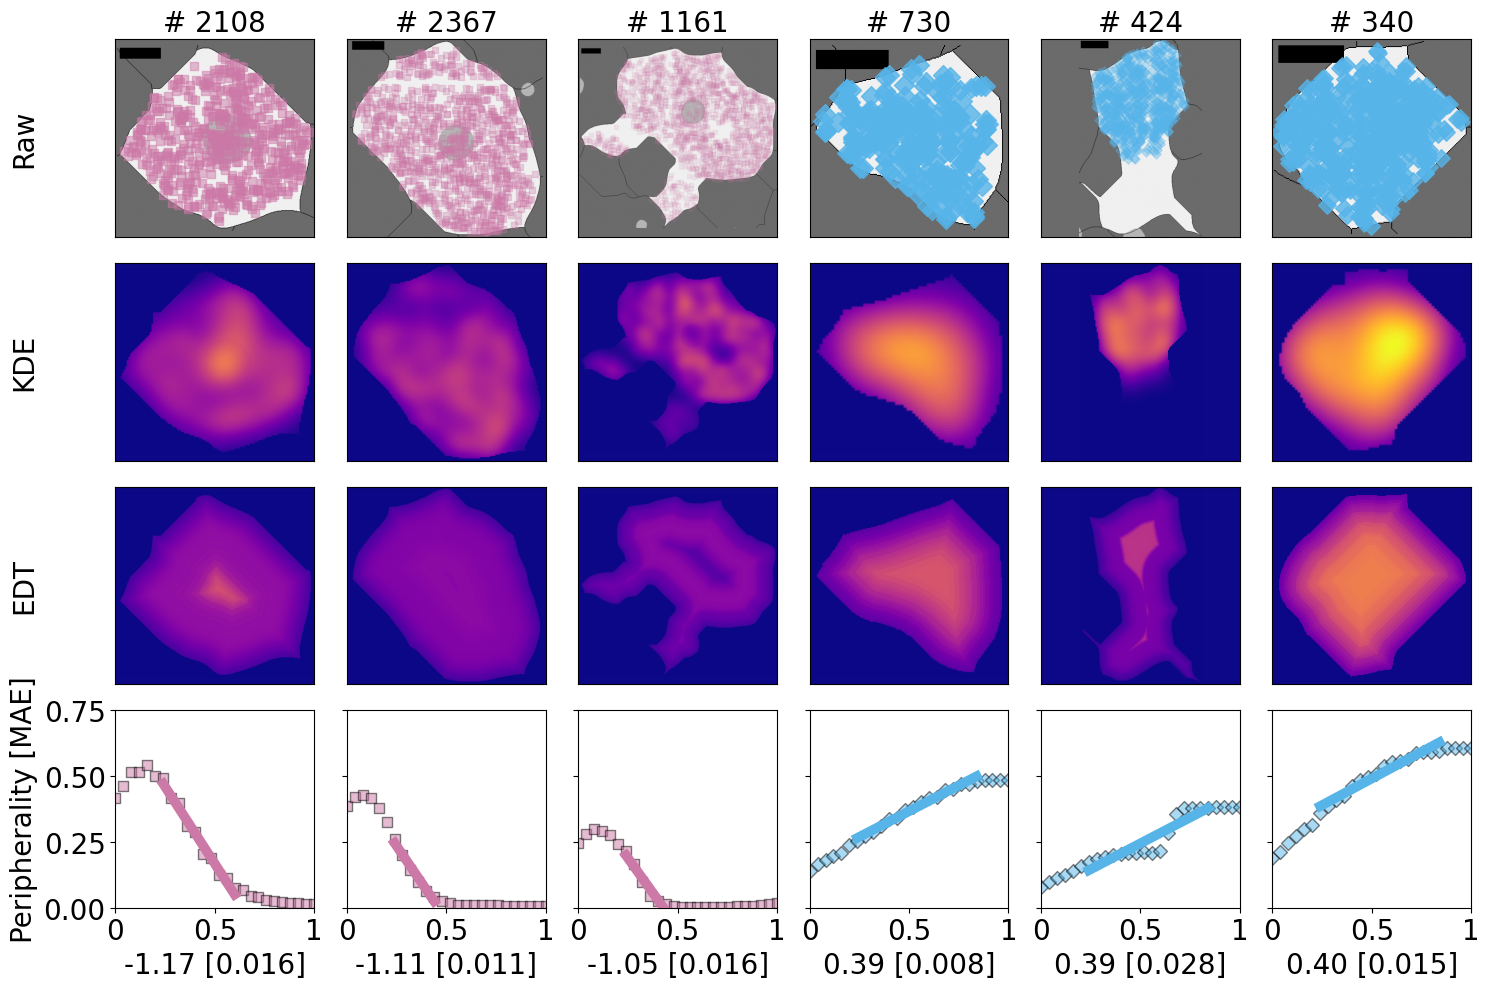

In [79]:
gidxs = 3*[26] + 3*[85]
fs = 20
fig, ax = plt.subplots(4, N, figsize=(2.5*N, 10), sharex=False, sharey=False)
for i in range(N):
    k = i
    cidx = cidxs[k]
    gidx = gidxs[k]
    t = transcriptomes[gidx]
    j = 0
    ax[j,i].imshow(hcells[k]+1, cmap=cellular_cmap, origin='lower', extent=hextent[k], vmin=0, vmax=nnuc+2);
    ax[j,i].scatter(*(hcoords[k][:2]), color=Cs[gidx], marker=Ms[gidx], alpha=halpha[k], s=int(4e6/hcells[k].size))
    ax[j,i].set_facecolor(wong[2])
    ax[j,i].set_title('# {}'.format(cidx), fontsize=fs)

    j += 1
    ax[j,i].imshow(np.max(hkde[k], axis=0), origin='lower', cmap=Cmap, vmin=0, vmax=loc_kmax, zorder=1)
    ax[j,i].set_facecolor( mpl.colormaps[ Cmap ](0) )

    j += 1
    ax[j,i].imshow(hedt[k], origin='lower', cmap=Cmap, vmin=0, vmax=loc_smax)
    ax[j,i].set_facecolor( mpl.colormaps[ Cmap ](0) )

    j += 1
    Ys = peripherality[cidx].loc[gidx].values
    m,b,mae,start,stop = df.loc[cidx, [t + '_-_' + c for c in ['m','b','mae','start','stop']]].values
    
    ax[j,i].scatter(Xs, Ys, color=Cs[gidx], marker=Ms[gidx], edgecolor='k', s=50, zorder=2, alpha=0.5)
    ax[j,i].plot( [ start, stop ], [m*start + b, m*stop+b], c=Cs[gidx] , zorder=3, lw=7)
    ax[j,i].set_xlabel('{:.2f} [{:.3f}]'.format(m,mae), fontsize=fs)
    ax[j,i].set_xlim(0, 1)
    ax[j,i].set_ylim(0, 0.75);
    ax[j,i].tick_params(labelsize=fs)
    ax[j,i].set_xticks([0,0.5,1],[0,0.5,1])

ylabs = ['Raw', 'KDE', 'EDT', 'Peripherality [MAE]']
for i in range(len(ylabs)):
    ax[i,0].set_ylabel(ylabs[i], fontsize=fs)

for a in ax.ravel()[:3*N]:
    a.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    a.set_aspect('equal', 'datalim')

for a in ax.ravel()[-N+1:]:
    a.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)

fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()
fig.tight_layout()
q = 'least'
if k > N:
    q = 'most'
filename = dst + 'peripherality.png'
print(filename)
plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

In [239]:
k > N

True

In [238]:
N

9

# Piecewise linear approximation

In [9]:
cc = ['m', 'b', 'len', 'start', 'stop', 'contig']
ce = ['MAPE', 'MAE', 'MSE']

colnames = []
dtypes = {}

for gidx in Genes:
    for n_seg in [2,3]:
        for j in range(n_seg):
            colnames += [ '{}-L{}{}-{}'.format(transcriptomes[gidx], n_seg, j, c) for c in cc ]
            for c in ['len', 'start', 'stop']:
                dtypes['{}-L{}{}-{}'.format(transcriptomes[gidx], n_seg, j, c)] = int
            dtypes['{}-L{}{}-{}'.format(transcriptomes[gidx], n_seg, j, 'contig')] = bool
        colnames += [ '{}-L{}-{}'.format(transcriptomes[gidx], n_seg, c) for c in ce ]

colnames = np.asarray(colnames)

In [17]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
data = np.zeros( (len(Cells), len(colnames)) )

for i in range(len(Cells)):
    cidx = Cells[i]
    kcol = 0
    for gidx in Genes:
        
        ys = peripherality[cidx].loc[gidx].values[pss]
        
        dys = np.gradient(ys, xs)
        
        for n_seg in [2,3]:
            #print(cidx, gidx, n_seg, sep='\t')
            rgr = tree.DecisionTreeRegressor(max_leaf_nodes=n_seg)
            rgr.fit(xs.reshape(-1, 1), dys.reshape(-1, 1))
            dys_dt = rgr.predict(xs.reshape(-1, 1)).flatten()
            
            uq, idxs, cts = np.unique(dys_dt, return_inverse=True, return_counts=True)
            css = ndimage.find_objects(idxs+1)
            
            contig = [ css[j][0].stop - css[j][0].start  == cts[j] for j in range(len(css)) ]
            
            y_pred = np.copy(ys)
            for j in range(len(css)):
                if cts[j] > 1:
                    linregress = stats.linregress(xs[css[j]], ys[css[j] ])
                    m, b = linregress.slope, linregress.intercept
                    y_pred[ css[j] ] = m*xs[ css[j] ] + b
                    data[i, kcol : kcol+6] = [m, b, cts[j], css[j][0].start, css[j][0].stop, contig[j] ]
                kcol += 6

            data[i, kcol] = metrics.mean_absolute_percentage_error(ys, y_pred); kcol += 1
            data[i, kcol] = metrics.mean_absolute_error(ys, y_pred); kcol += 1
            data[i, kcol] = metrics.mean_squared_error(ys, y_pred); kcol += 1

In [18]:
df = pd.DataFrame(data, index=Cells, columns=colnames).astype(dtypes)
for gidx in Genes:
    t = transcriptomes[gidx]
    df[t+'_L'] = np.where( (df[ t+'-L2-MAE' ] - df[ t+'-L3-MAE' ] < 0.005).values, 2, 3)

c = [t+'_peripherality' for t in transcriptomes[Genes]]
c += [t+'_lenpct' for t in transcriptomes[Genes]]
c += [t+'_MAE' for t in transcriptomes[Genes]]
peri = pd.DataFrame(np.zeros((len(Cells), len(c))), index=Cells, columns=c)

for cidx in Cells:
    for gidx in Genes:
        t = transcriptomes[gidx]
        n_seg = df.loc[cidx, t+'_L']
        
        k = df.loc[cidx, ['{}-L{}{}-len'.format(t, n_seg, k) for k in range(n_seg)] ].argmax()
        peri.loc[cidx, '{}_peripherality'.format(t)] = df.loc[cidx, '{}-L{}{}-m'.format(t, n_seg, k)]
        peri.loc[cidx, '{}_lenpct'.format(t)] = df.loc[cidx, '{}-L{}{}-len'.format(t, n_seg, k)]
        peri.loc[cidx, '{}_MAE'.format(t)] = df.loc[cidx, '{}-L{}-MAE'.format(t, n_seg)]

for gidx in Genes:
    peri[transcriptomes[gidx] + '_lenpct'] = peri[transcriptomes[gidx] + '_lenpct']/len(xs)

In [30]:
idx = df[df['GLYMA_05G092200_L'] == 3].index.values
peri.loc[idx].sort_values(by = 'GLYMA_05G092200_peripherality', ascending=False).head()

,GLYMA_17G195900_peripherality,GLYMA_05G092200_peripherality,GLYMA_17G195900_lenpct,GLYMA_05G092200_lenpct,GLYMA_17G195900_MAE,GLYMA_05G092200_MAE
2219,0.387817,0.020805,0.526316,0.473684,0.004181,0.001866
2226,0.113142,-0.013951,0.631579,0.526316,0.001805,0.002183
883,0.220557,-0.081768,0.526316,0.473684,0.004317,0.002449
1347,0.058888,-0.132565,0.789474,0.473684,0.001274,0.001824
1881,0.081479,-0.165505,0.684211,0.684211,0.004979,0.003443


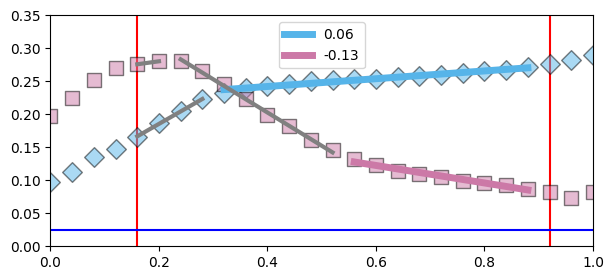

In [215]:
cidx = 1347

fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].axvline(Xs[pss.start], c='r', zorder=1)
ax[j].axvline(Xs[pss.stop], c='r', zorder=1)
ax[j].axhline(0.025, c='b', zorder=1)
xs = Xs[pss]
for gidx in Genes:
    t = transcriptomes[gidx]
    n_seg = df.loc[cidx, t+'_L']
    Ys = peripherality[cidx].loc[gidx].values

    ax[j].scatter(Xs, Ys, color=Cs[gidx], marker=Ms[gidx], edgecolor='k', s=100, zorder=2, alpha=0.5)

    k = df.loc[cidx, ['{}-L{}{}-len'.format(t, n_seg, k) for k in range(n_seg)] ].argmax()
    m, b = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['m','b'] ] ].values.astype(float)
    start, stop = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['start','stop'] ] ].values.astype(int)
    stop -= 1
    ax[j].plot( [ xs[start], xs[stop] ], [m*xs[start] + b, m*xs[stop]+b], c=Cs[gidx] , zorder=3, lw=5, label='{:.2f}'.format(m))

    for k in np.setdiff1d(range(n_seg), [k]):
        m, b = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['m','b'] ] ].values.astype(float)
        ll, start, stop = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['len', 'start','stop'] ] ].values.astype(int)
        stop -= 1
        ax[j].plot( [ xs[start], xs[stop] ], [m*xs[start] + b, m*xs[stop]+b], c='gray' , zorder=4, lw=3)


ax[j].legend()
ax[j].set_xlim(0,1)
ax[j].set_ylim(0, max([peripherality[cidx].max(axis=None), 0.3])+0.05);